In [56]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [57]:
# Historical dat SP500 Index from 1942 to 2024

sp500_data = yf.download("^GSPC", period="82y")

[*********************100%%**********************]  1 of 1 completed


In [58]:
sp500_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Features description 

Open: The 'Open' price is the price at which a stock or index begins trading when the market opens for the day. It's the first traded price of the day.

High: The 'High' price is the highest price at which a stock or index traded during the trading day.

Low: The 'Low' price is the lowest price at which a stock or index traded during the trading day.

Close: The 'Close' price is the last price at which a stock or index traded during the trading day. It is the final price before the market closes.

Adj Close (Adjusted Close): The 'Adj Close' price is the closing price after adjustments for all applicable splits and dividend distributions. For indices like the S&P 500, the 'Adj Close' reflects the total return of the index which includes reinvested dividends of the index's constituents.

Volume: The 'Volume' represents the total number of shares (for stocks) or contracts (for indices and other securities) traded during the trading day. It's an indicator of the activity and liquidity of the security - higher volume often suggests higher interest and activity in the security.

--

dd (Drawdown): measures the percentage decline from the peak value of a security or index, calculated as (Current Value - Peak Value) / Peak Value.

ddn (Drawdown Number): unique identifier to each drawdown period, marking the start of a new drawdown when the current drawdown value is less than 0 and the previous drawdown value was 0.

ddmax (Maximum Drawdown): max drawdown within each drawdown period, representing the largest percentage decline from the peak value within that period.

bear: identifies periods of significant decline by checking if the maximum drawdown within a drawdown period is less than -0.2 and less than the cumulative minimum drawdown within the same period.

bearn (Bear Market Number): unique identifier to each bear market period, marking the start of a new bear market when the current period is marked as a bear market and the previous period is not.

             min        max
bearn                      
1     1946-05-31 1949-06-10
2     1956-08-06 1957-10-21
3     1961-12-13 1962-06-25
4     1966-02-10 1966-10-06
5     1968-12-02 1970-05-25
6     1973-01-12 1974-10-02
7     1980-12-01 1982-08-11
8     1987-08-26 1987-12-03
9     2000-03-27 2002-10-08
10    2007-10-10 2009-03-06
11    2020-02-20 2020-03-20
12    2022-01-04 2022-10-11


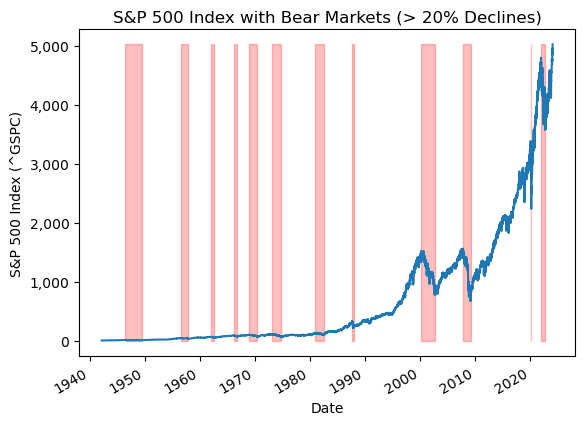

In [59]:
# Calculate bear periods

sp500_data['dd'] = sp500_data['Adj Close'].div(sp500_data['Adj Close'].cummax()).sub(1)
sp500_data['ddn'] = ((sp500_data['dd'] < 0.) & (sp500_data['dd'].shift() == 0.)).cumsum()
sp500_data['ddmax'] = sp500_data.groupby('ddn')['dd'].transform('min')
sp500_data['bear'] = (sp500_data['ddmax'] < -0.2) & (sp500_data['ddmax'] < sp500_data.groupby('ddn')['dd'].transform('cummin'))
sp500_data['bearn'] = ((sp500_data['bear'] == True) & (sp500_data['bear'].shift() == False)).cumsum()

bears = sp500_data.reset_index().query('bear == True').groupby('bearn')['Date'].agg(['min', 'max'])
print(bears)

sp500_data['Adj Close'].plot()

for i, row in bears.iterrows():
    plt.fill_between(row, sp500_data['Adj Close'].max(), alpha=0.25, color='r')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('S&P 500 Index (^GSPC)')
plt.title('S&P 500 Index with Bear Markets (> 20% Declines)')

plt.show()

In [60]:
sp500_data['daily_return'] = (sp500_data['Adj Close'] /sp500_data['Adj Close'].shift(1)) - 1
sp500_data['daily_return_pct'] = sp500_data['Close'].pct_change() * 100

In [61]:
sp500_data.fillna(0, inplace=True)

In [62]:
sp500_data.dtypes

Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dd                  float64
ddn                   int64
ddmax               float64
bear                   bool
bearn                 int64
daily_return        float64
daily_return_pct    float64
dtype: object

In [63]:
sp500_data.head()

,Open,High,Low,Close,Adj Close,Volume,dd,ddn,ddmax,bear,bearn,daily_return,daily_return_pct
Date,,,,,,,,,,,,,
1942-02-10,8.62,8.62,8.62,8.62,8.62,0,0.000000,0,0.000000,False,0,0.000000,0.000000
1942-02-11,8.60,8.60,8.60,8.60,8.60,0,-0.002320,1,-0.002320,False,0,-0.002320,-0.232013
1942-02-13,8.62,8.62,8.62,8.62,8.62,0,0.000000,1,-0.002320,False,0,0.002326,0.232552
1942-02-16,8.65,8.65,8.65,8.65,8.65,0,0.000000,1,-0.002320,False,0,0.003480,0.348025
1942-02-17,8.49,8.49,8.49,8.49,8.49,0,-0.018497,2,-0.136416,False,0,-0.018497,-1.849709


# Compounded returns df for bull and bear market periods by taking into account the daily returns over the specified time intervals.


In [64]:
#Compounded returns for bull and bear market periods by taking into account the daily returns over the specified time intervals.

bull_periods = []
bear_periods = []

current_period_start = None
current_bear = None

for index, row in sp500_data.iterrows():
    if current_bear is None:
        current_bear = row['bear']
        current_period_start = index
    elif row['bear'] != current_bear:
     
        if current_bear:
            bear_periods.append((current_period_start, index - pd.Timedelta(days=1)))
        else:
            bull_periods.append((current_period_start, index - pd.Timedelta(days=1)))
            
        # Reset variables for the next period
        current_bear = row['bear']
        current_period_start = index

if current_bear:
    bear_periods.append((current_period_start, sp500_data.index[-1]))
else:
    bull_periods.append((current_period_start, sp500_data.index[-1]))

def calculate_compounded_return(df, start_date, end_date):
    # The product of (1 + return) for each day compounded
    compounded_return = (df.loc[start_date:end_date, 'daily_return'] + 1).prod() - 1
    return compounded_return

market_type_with_return = []

for i, period in enumerate(bull_periods, 1):
    start_date, end_date = period
    compounded_return_percentage = calculate_compounded_return(sp500_data, start_date, end_date) * 100
    num_days = (end_date - start_date).days + 1
    market_type_with_return.append((f"Bull Market Period {i}", round(compounded_return_percentage, 1), num_days, start_date, end_date, 'Bull'))


for i, period in enumerate(bear_periods, 1):
    start_date, end_date = period
    compounded_return_percentage = calculate_compounded_return(sp500_data, start_date, end_date) * 100
    num_days = (end_date - start_date).days + 1
    market_type_with_return.append((f"Bear Market Period {i}", round(compounded_return_percentage, 1), num_days, start_date, end_date, 'Bear'))
    

return_market_type_df = pd.DataFrame(market_type_with_return, columns=['Period', 'Total Return (%)', 'Number of Days', 'Start Date', 'End Date', 'Market Type'])

In [65]:
return_market_type_df.head()

,Period,Total Return (%),Number of Days,Start Date,End Date,Market Type
0,Bull Market Period 1,123.3,1571,1942-02-10,1946-05-30,Bull
1,Bull Market Period 2,259.4,2611,1949-06-13,1956-08-05,Bull
2,Bull Market Period 3,85.5,1513,1957-10-22,1961-12-12,Bull
3,Bull Market Period 4,79.3,1325,1962-06-26,1966-02-09,Bull
4,Bull Market Period 5,46.3,787,1966-10-07,1968-12-01,Bull


In [17]:
# Total return annualized

def calculate_annualized_return(compounded_return, num_days):
    annualized_return = (np.power(1 + compounded_return, 365 / num_days) - 1) * 100
    return annualized_return

annualized_returns = []

for i, period in enumerate(bull_periods, 1):
    start_date, end_date = period
    compounded_return_percentage = calculate_compounded_return(sp500_data, start_date, end_date) * 100
    num_days = (end_date - start_date).days + 1
    annualized_return_percentage = calculate_annualized_return(compounded_return_percentage / 100, num_days)
    annualized_returns.append(round(annualized_return_percentage, 1))

for i, period in enumerate(bear_periods, 1):
    start_date, end_date = period
    compounded_return_percentage = calculate_compounded_return(sp500_data, start_date, end_date) * 100
    num_days = (end_date - start_date).days + 1
    annualized_return_percentage = calculate_annualized_return(compounded_return_percentage / 100, num_days)
    annualized_returns.append(round(annualized_return_percentage, 1))

return_market_type_df['Annualized Return (%)'] = annualized_returns

return_market_type_df.head()

,Period,Total Return (%),Number of Days,Start Date,End Date,Market Type,Annualized Return (%)
0,Bull Market Period 1,123.3,1571,1942-02-10,1946-05-30,Bull,20.5
1,Bull Market Period 2,259.4,2611,1949-06-13,1956-08-05,Bull,19.6
2,Bull Market Period 3,85.5,1513,1957-10-22,1961-12-12,Bull,16.1
3,Bull Market Period 4,79.3,1325,1962-06-26,1966-02-09,Bull,17.5
4,Bull Market Period 5,46.3,787,1966-10-07,1968-12-01,Bull,19.3


In [66]:
# Duration formatted

def calculate_duration(start_date, end_date):
    duration = end_date - start_date

    days = duration.days
    months = days / 30
    years = days / 365

    if days < 30:
        return f"{months:.1f} Mos"
    elif days < 365:
        return f"{months:.1f} Mos"
    else:
        return f"{years:.1f} Yrs"

In [67]:
return_market_type_df['Duration_Formatted'] = return_market_type_df.apply(lambda row: calculate_duration(row['Start Date'], row['End Date']), axis=1)

In [68]:
return_market_type_df.head(26)

,Period,Total Return (%),Number of Days,Start Date,End Date,Market Type,Duration_Formatted
0,Bull Market Period 1,123.3,1571,1942-02-10,1946-05-30,Bull,4.3 Yrs
1,Bull Market Period 2,259.4,2611,1949-06-13,1956-08-05,Bull,7.2 Yrs
2,Bull Market Period 3,85.5,1513,1957-10-22,1961-12-12,Bull,4.1 Yrs
3,Bull Market Period 4,79.3,1325,1962-06-26,1966-02-09,Bull,3.6 Yrs
4,Bull Market Period 5,46.3,787,1966-10-07,1968-12-01,Bull,2.2 Yrs
5,Bull Market Period 6,71.2,962,1970-05-26,1973-01-11,Bull,2.6 Yrs
6,Bull Market Period 7,121.7,2251,1974-10-03,1980-11-30,Bull,6.2 Yrs
7,Bull Market Period 8,228.2,1840,1982-08-12,1987-08-25,Bull,5.0 Yrs
8,Bull Market Period 9,578.2,4497,1987-12-04,2000-03-26,Bull,12.3 Yrs
9,Bull Market Period 10,96.0,1827,2002-10-09,2007-10-09,Bull,5.0 Yrs


# Plot the cumulative return % over years for SP500

In [27]:
sp500_data.reset_index(inplace=True)

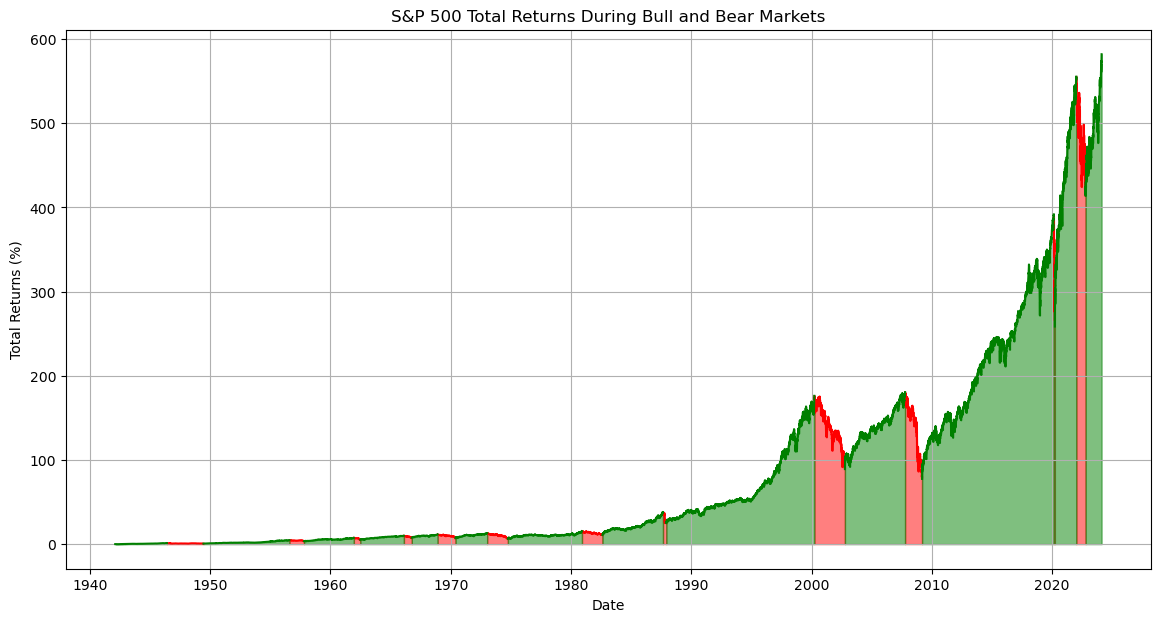

In [28]:
# Check cumulative return (%)

sp500_data['Period'] = ''

# Loop over the periods and assign the period name to the new column in sp500_data
for _, row in return_market_type_df.iterrows():
    mask = (sp500_data['Date'] >= row['Start Date']) & (sp500_data['Date'] <= row['End Date'])
    sp500_data.loc[mask, 'Period'] = row['Period']

# Now, you can calculate the total returns for each period
sp500_data['Total Return'] = (sp500_data['daily_return'] + 1).cumprod() - 1

# Now plot the data
plt.figure(figsize=(14, 7))

for period, group in sp500_data.groupby('Period'):
    market_type = 'Bull' if 'Bull' in period else 'Bear'
    color = 'green' if market_type == 'Bull' else 'red'
    plt.plot(group['Date'], group['Total Return'], label=period, color=color)
    plt.fill_between(group['Date'], group['Total Return'], 0, color=color, alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Total Returns (%)')
plt.title('S&P 500 Total Returns During Bull and Bear Markets')
plt.grid(True)
plt.show()

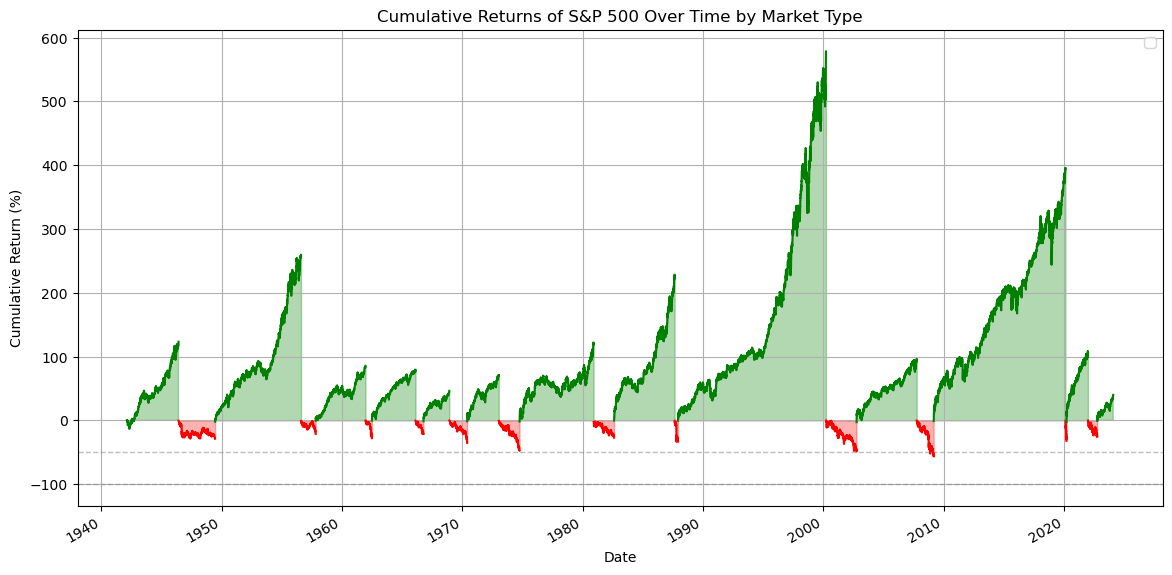

In [29]:
def calculate_cumulative_returns(df):
    # Create a column for cumulative returns that resets at the start of each new period
    df['cumulative_return'] = 0
    df['period_return'] = 0
    df['period_id'] = 0
    period_id = 0
    running_return = 0
    
    for i, row in df.iterrows():
        if i == 0 or row['bear'] != df.at[i - 1, 'bear']:  # New period identified
            running_return = 0
            period_id += 1
        daily_return = row['daily_return'] + 1
        running_return = running_return * daily_return if running_return != 0 else daily_return
        df.at[i, 'cumulative_return'] = (running_return - 1) * 100
        df.at[i, 'period_id'] = period_id
    
    return df


sp500_data = calculate_cumulative_returns(sp500_data)


fig, ax = plt.subplots(figsize=(14, 7))

# Plot additional reference lines at -50% and -100%
ax.axhline(-50, color='grey', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(-100, color='grey', linestyle='--', linewidth=1, alpha=0.5)

# Iterate over each period and plot it separately
for period_id, period_df in sp500_data.groupby('period_id'):
    
    color = 'green' if period_df['bear'].iloc[0] == False else 'red'
    
    # Extract the dates and cumulative returns for the period
    dates = period_df['Date']
    cumulative_returns = period_df['cumulative_return']
    
    
    ax.plot(dates, cumulative_returns, color=color)
    
    
    ax.fill_between(dates, cumulative_returns, 0, where=(cumulative_returns >= 0), interpolate=True, color=color, alpha=0.3)
    ax.fill_between(dates, cumulative_returns, 0, where=(cumulative_returns <= 0), interpolate=True, color=color, alpha=0.3)


ax.xaxis_date()
fig.autofmt_xdate()


ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (%)')
ax.set_title('Cumulative Returns of S&P 500 Over Time by Market Type')


ax.grid(True)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.show()

# Df for Data visualization with Tableau

In [53]:
sp500_tableau_df = sp500_data[['Date', 'daily_return', 'bear']].copy()

In [60]:
def calculate_cumulative_returns(df):
    period_id = 1
    df['cumulative_return'] = 0  # Initialize the column for cumulative return
    df['period_id'] = 0  # Initialize the column for period ID
    
    previous_bear = None  # To track the previous 'bear' value

    for position, (index, row) in enumerate(df.iterrows()):
        # Skip the first row to avoid indexing errors
        if position == 0:
            previous_bear = row['bear']
            df.at[index, 'period_id'] = period_id
            continue
        
        
        if row['bear'] != previous_bear:
            previous_bear = row['bear']
            period_id += 1
        
        
        running_return = (1 + row['daily_return']) * (1 + df.iloc[position - 1]['cumulative_return']) - 1
        
       
        df.at[index, 'cumulative_return'] = running_return
        df.at[index, 'period_id'] = period_id

    return df


sp500_tableau_df = calculate_cumulative_returns(sp500_tableau_df)

In [32]:
sp500_tableau_df['reset'] = sp500_tableau_df['bear'].diff().fillna(0).ne(0).astype(int)

In [33]:
sp500_tableau_df.dtypes

Date                 datetime64[ns]
daily_return                float64
bear                           bool
cumulative_return           float64
period_return                 int64
period_id                     int64
reset                         int64
dtype: object

In [34]:
# Add recession periods US to the data set - https://fred.stlouisfed.org/series/USREC

usrec = pd.read_csv('/Users/amandine/hist/USREC.csv')

usrec.head()

,DATE,USREC
0,1854-12-01,1
1,1855-01-01,0
2,1855-02-01,0
3,1855-03-01,0
4,1855-04-01,0


In [35]:
usrec['DATE'] = pd.to_datetime(usrec['DATE'])

In [37]:
usrec.set_index('DATE', inplace=True)
recession_daily = usrec.resample('D').ffill()

In [38]:
sp500_tableau_df.set_index('Date', inplace=True)

In [39]:
# Merge on Date

sp500_tableau_df_usrec = sp500_tableau_df.merge(recession_daily, left_index=True, right_index=True, how='left')

In [40]:
nan_rows = sp500_tableau_df_usrec[sp500_tableau_df_usrec['USREC'].isna()]

In [41]:
sp500_tableau_df_usrec['USREC'] = sp500_tableau_df_usrec['USREC'].fillna(0)

In [42]:
sp500_tableau_df_usrec.reset_index(inplace=True)

In [43]:
sp500_tableau_df_usrec.rename(columns={
    'Date': 'date',
    'daily_return': 'daily return',
    'bear': 'bear market',
    'cumulative_return': 'cumulative return',
    'period_return': 'period return',
    'period_id': 'period id',
    'reset': 'reset indicator',
    'Market_type': 'market type',
    'USREC': 'us recession indicator'
}, inplace=True)


In [ ]:
sp500_tableau_df_usrec['us recession indicator'] = sp500_tableau_df_usrec['us recession indicator'].astype(bool)

In [48]:
sp500_tableau_df_usrec['cumulative return'] = sp500_tableau_df_usrec['cumulative return'].round(3)

In [57]:
sp500_tableau_df_usrec.head(5)

,date,daily return,bear market,cumulative return,period return,period id,reset indicator,us recession indicator
0,1942-02-10,0.000000,False,0.000,0,1,0,False
1,1942-02-11,-0.002320,False,-0.232,0,1,0,False
2,1942-02-13,0.002326,False,-0.000,0,1,0,False
3,1942-02-16,0.003480,False,0.348,0,1,0,False
4,1942-02-17,-0.018497,False,-1.508,0,1,0,False


# Predictions

# VAR Method

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from pandas_datareader import data as web
from statsmodels.stats.stattools import durbin_watson

In [134]:
# Data preparation for VAR analysis

In [71]:
sp500 = yf.download("^GSPC", period="82y")

[*********************100%%**********************]  1 of 1 completed


In [72]:
adj_close_df = sp500[['Adj Close']]

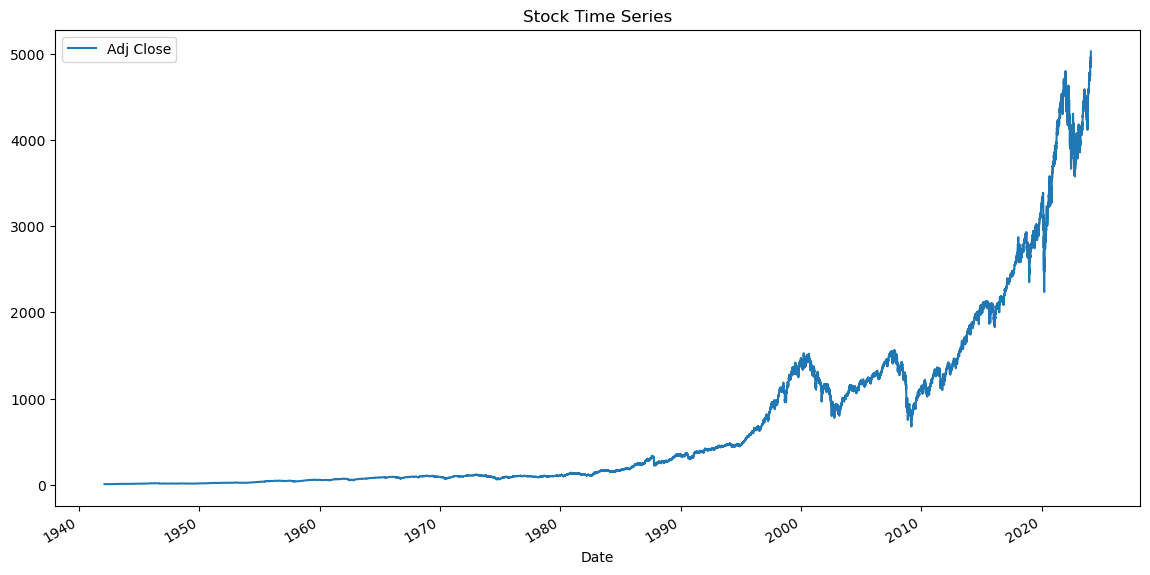

In [73]:
adj_close_df.plot(figsize=(14,7))
plt.title('Stock Time Series')
plt.show()

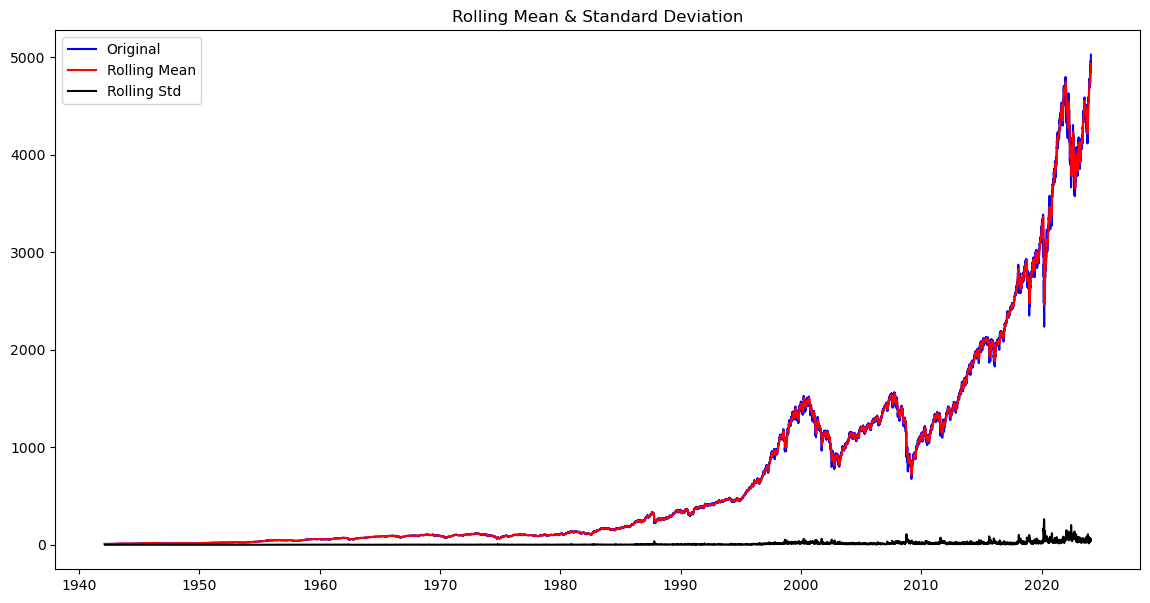

Results of Dickey-Fuller Test:
Test Statistic                     4.880487
p-value                            1.000000
#Lags Used                        46.000000
Number of Observations Used    20572.000000
Critical Value (1%)               -3.430668
Critical Value (5%)               -2.861681
Critical Value (10%)              -2.566845
dtype: float64
The series is not stationary.


In [74]:
# Stationarity Checks

def check_stationarity(time_series, window=12, cutoff=0.05):
    # Determing rolling statistics
    rolmean = time_series.rolling(window).mean()
    rolstd = time_series.rolling(window).std()

    # Plot rolling statistics:
    plt.figure(figsize=(14, 7))
    plt.plot(time_series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series.dropna(), autolag='AIC')  # dropna() to remove any NaNs in the series
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    if dftest[1] <= cutoff:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

check_stationarity(adj_close_df['Adj Close'])

Checking stationarity after differencing for ^GSPC:


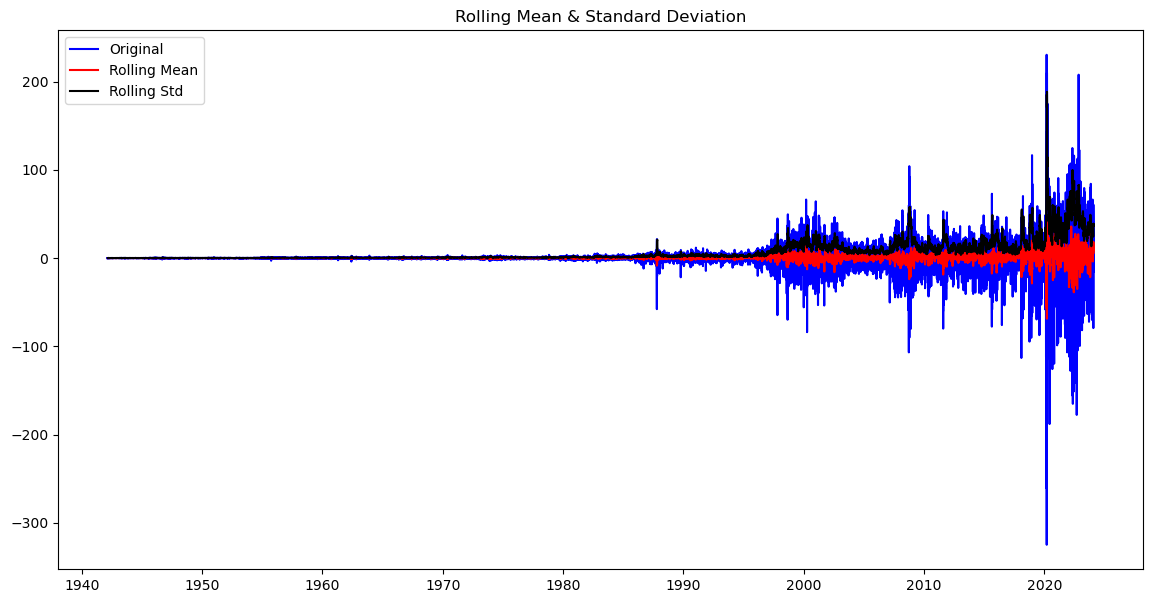

Results of Dickey-Fuller Test:
Test Statistic                   -22.364606
p-value                            0.000000
#Lags Used                        46.000000
Number of Observations Used    20571.000000
Critical Value (1%)               -3.430668
Critical Value (5%)               -2.861681
Critical Value (10%)              -2.566845
dtype: float64
The series is stationary.


In [75]:
# Differencing
df_diff = adj_close_df.diff().dropna()

print('Checking stationarity after differencing for ^GSPC:')
check_stationarity(df_diff['Adj Close'])

In [149]:
sp500['Price Range'] = sp500['High'] - sp500['Low']
sp500['Daily Return'] = sp500['Close'] - sp500['Open']

In [151]:
# variables for VAR model

var_df = sp500[['Adj Close', 'Volume', 'Price Range', 'Daily Return']]

In [152]:
model = VAR(var_df)
results = model.select_order(15)
print(results.summary())

/Users/amandine/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        67.28       67.29   1.663e+29       67.28
1        53.60       53.60   1.891e+23       53.60
2        52.12       52.13   4.323e+22       52.13
3        51.78       51.80   3.072e+22       51.79
4        51.62       51.65   2.630e+22       51.63
5        51.55       51.58   2.447e+22       51.56
6        51.49       51.53   2.300e+22       51.50
7        51.46       51.51   2.242e+22       51.48
8        51.44       51.49   2.181e+22       51.45
9        51.41       51.47   2.128e+22       51.43
10       51.38       51.45   2.069e+22       51.40
11       51.37       51.44   2.046e+22       51.40
12       51.37       51.45   2.044e+22       51.40
13       51.36       51.45   2.030e+22       51.39
14       51.36       51.44   2.014e+22       51.39
15      51.35*      51.44*  1.994e+22*      51.38*
-------------------------------

In [153]:
optimal_lag = results.selected_orders['aic']
var_model = model.fit(optimal_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Feb, 2024
Time:                     16:33:19
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    51.4408
Nobs:                     20604.0    HQIC:                   51.3775
Log likelihood:          -645674.    FPE:                1.99364e+22
AIC:                      51.3468    Det(Omega_mle):     1.97020e+22
--------------------------------------------------------------------
Results for equation Adj Close
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.008532         0.142935            0.060           0.952
L1.Adj Close             0.892687         0.015831           56.389           0.000
L1.Volume               -0.000000         0.

In [154]:
out = durbin_watson(var_model.resid)

for col, val in zip(var_df.columns, out):
    print(col, ':', round(val, 2))

Adj Close : 2.0
Volume : 2.0
Price Range : 2.0
Daily Return : 2.0


In [161]:
forecast_steps = 1000  
forecast = var_model.forecast(var_df.values[-optimal_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=var_df.index[-1], periods=forecast_steps+1, freq='D', closed='right'), columns=var_df.columns)
print(forecast_df)


              Adj Close        Volume  Price Range  Daily Return
2024-02-10  5030.392780  4.057217e+09    28.866819     -0.946150
2024-02-11  5020.279175  4.134826e+09    31.626750     -8.313257
2024-02-12  5023.577131  4.264845e+09    35.980995     -2.276621
2024-02-13  5024.639418  4.275926e+09    37.279543      0.248719
2024-02-14  5022.291307  4.241279e+09    36.868211     -1.965924
...                 ...           ...          ...           ...
2026-11-01  6967.406041  8.775812e+09    83.627462    -20.610573
2026-11-02  6969.751556  8.778912e+09    83.655557    -20.634161
2026-11-03  6972.097874  8.782014e+09    83.683662    -20.657754
2026-11-04  6974.444996  8.785115e+09    83.711776    -20.681353
2026-11-05  6976.792923  8.788217e+09    83.739900    -20.704957

[1000 rows x 4 columns]


/var/folders/k_/zzt_gt2j0mgf2704mzjrzkcr0000gn/T/ipykernel_27641/1067092982.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=var_df.index[-1], periods=forecast_steps+1, freq='D', closed='right'), columns=var_df.columns)


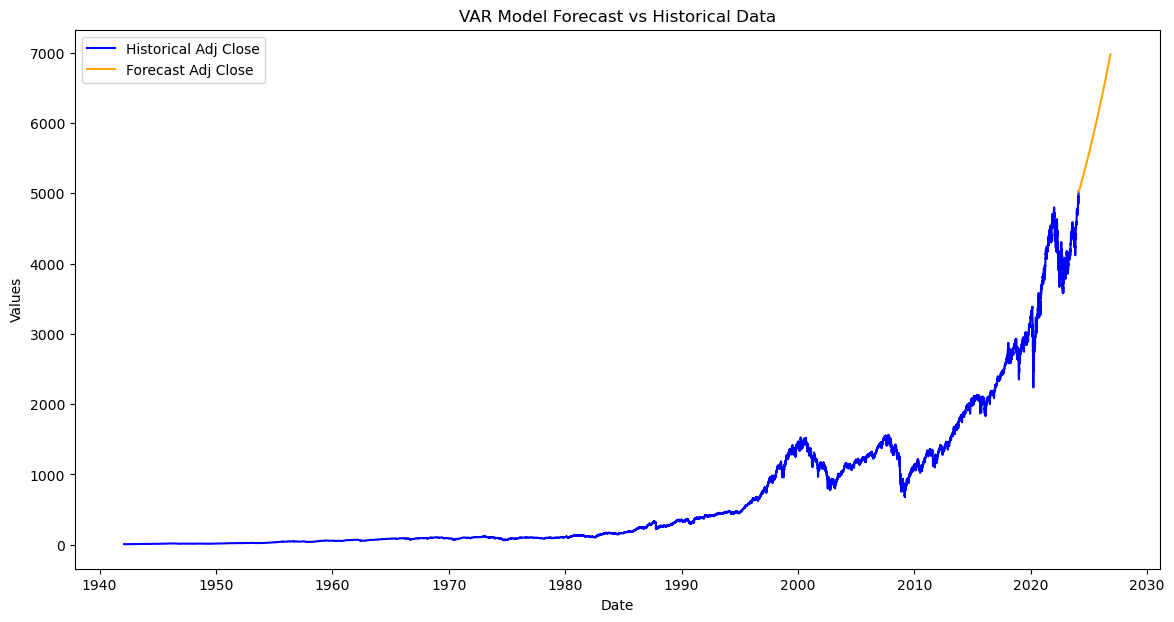

In [162]:
# Plot the historical data
plt.figure(figsize=(14, 7))

# Assuming 'Adj Close' and 'Volume' as example variables
plt.plot(var_df.index, var_df['Adj Close'], label='Historical Adj Close', color='blue')


# Plot the forecasted data
plt.plot(forecast_df.index, forecast_df['Adj Close'], label='Forecast Adj Close', color='orange')


plt.title('VAR Model Forecast vs Historical Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# LSTM predictions

In [7]:
# Lstm price prediction

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [24]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('^GSPC', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [40]:
end = '2024-02-09'
start = '2020-01-02'

testingData = yf.download('^GSPC', start=start, end=end)
testingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000


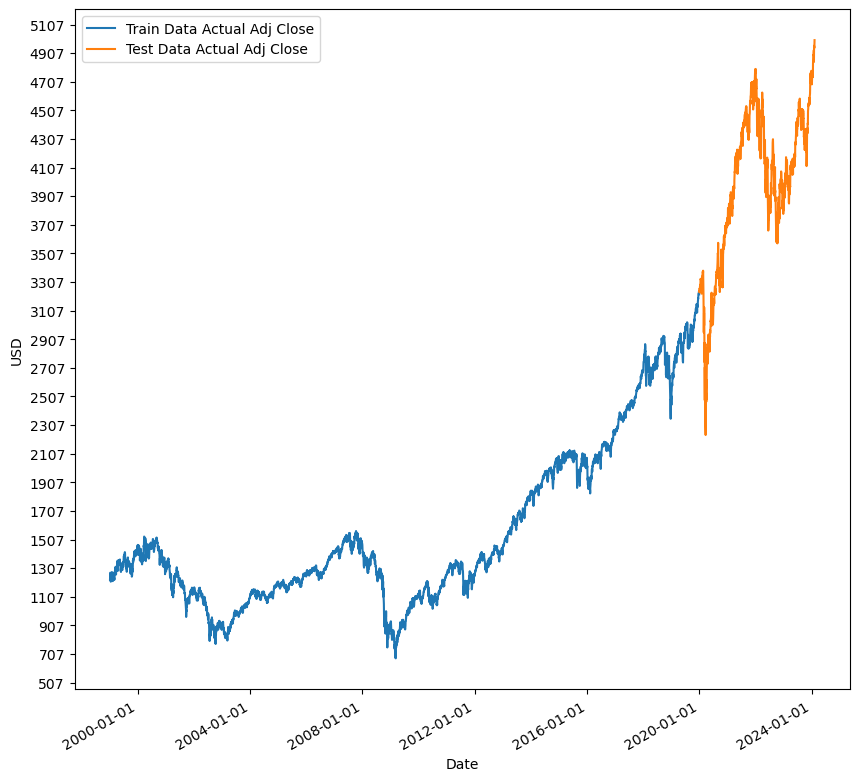

In [41]:
plt.figure(figsize=(10,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=200))

plt.plot(trainingData.index, trainingData['Adj Close'], label='Train Data Actual Adj Close')
plt.plot(testingData.index, testingData['Adj Close'], label='Test Data Actual Adj Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [42]:
trainDataScaled = sc.fit_transform(trainingData['Adj Close'].values.reshape(-1, 1))
testDataScaled = sc.transform(testingData['Adj Close'].values.reshape(-1, 1))


In [43]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])
      
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

In [44]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 200)           161600    
                                                                 
 dropout_8 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_9 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_9 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_10 (LSTM)              (None, 20, 200)           320800    
                                                                 
 dropout_10 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_11 (LSTM)              (None, 200)              

In [45]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


In [46]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 17s 92ms/step - loss: 0.1707 - root_mean_squared_error: 0.4132 - mean_absolute_error: 0.3468


In [47]:
len(xTrain)

5262

Epoch 1/100
31/31 [==============================] - 37s 735ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - mean_absolute_error: 0.0684 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - val_mean_absolute_error: 0.0686
Epoch 2/100
31/31 [==============================] - 24s 761ms/step - loss: 0.0129 - root_mean_squared_error: 0.1138 - mean_absolute_error: 0.0902 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2687 - val_mean_absolute_error: 0.2506
Epoch 3/100
31/31 [==============================] - 18s 569ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - mean_absolute_error: 0.0857 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1807 - val_mean_absolute_error: 0.1578
Epoch 4/100
31/31 [==============================] - 19s 621ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - mean_absolute_error: 0.0922 - val_loss: 0.1309 - val_root_mean_squared_error: 0.3617 - val_mean_absolute_error: 0.3418
Epoch 5/100
31/31 [=============================

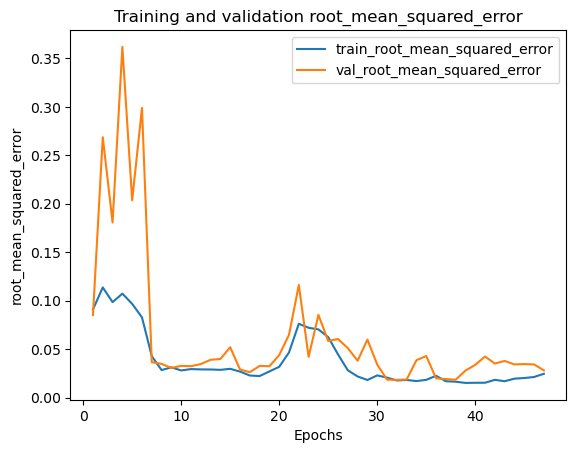

In [48]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128, 
    validation_split = 0.25, 
    verbose=1, 
    callbacks=[earlyStopping], 
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [49]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])
      
xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))  

In [50]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse 

32/32 [==============================] - 4s 71ms/step


0.23706373640232334

In [51]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

32/32 [==============================] - 2s 69ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371 - mean_absolute_error: 0.2165


In [52]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)

In [53]:
df = df1.join(df2)
df = df.set_index('Date')

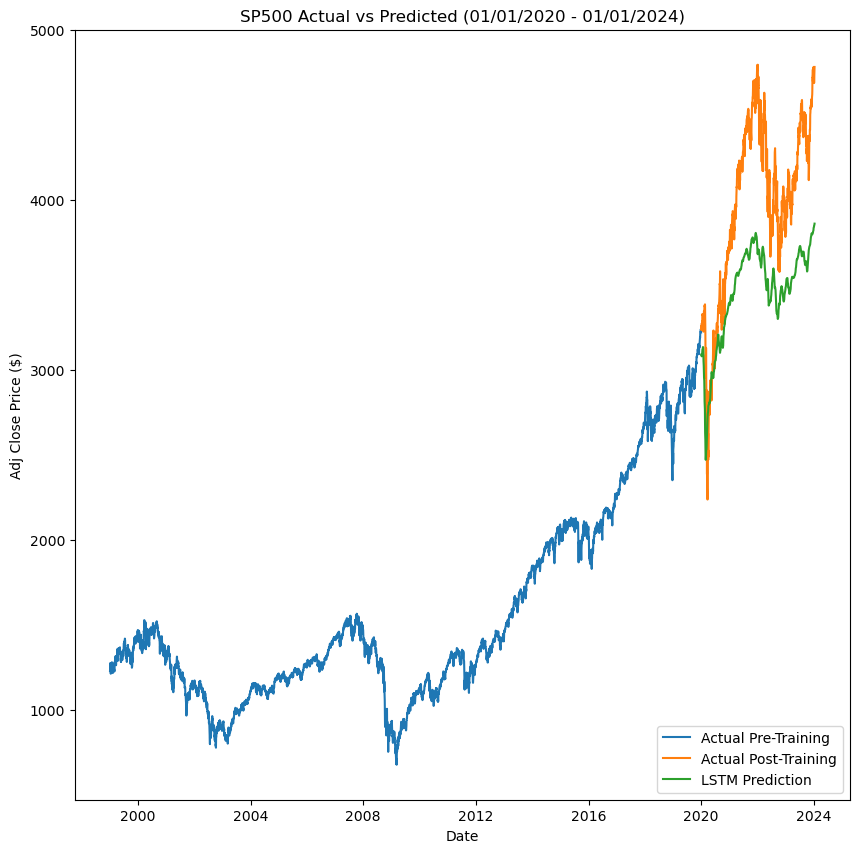

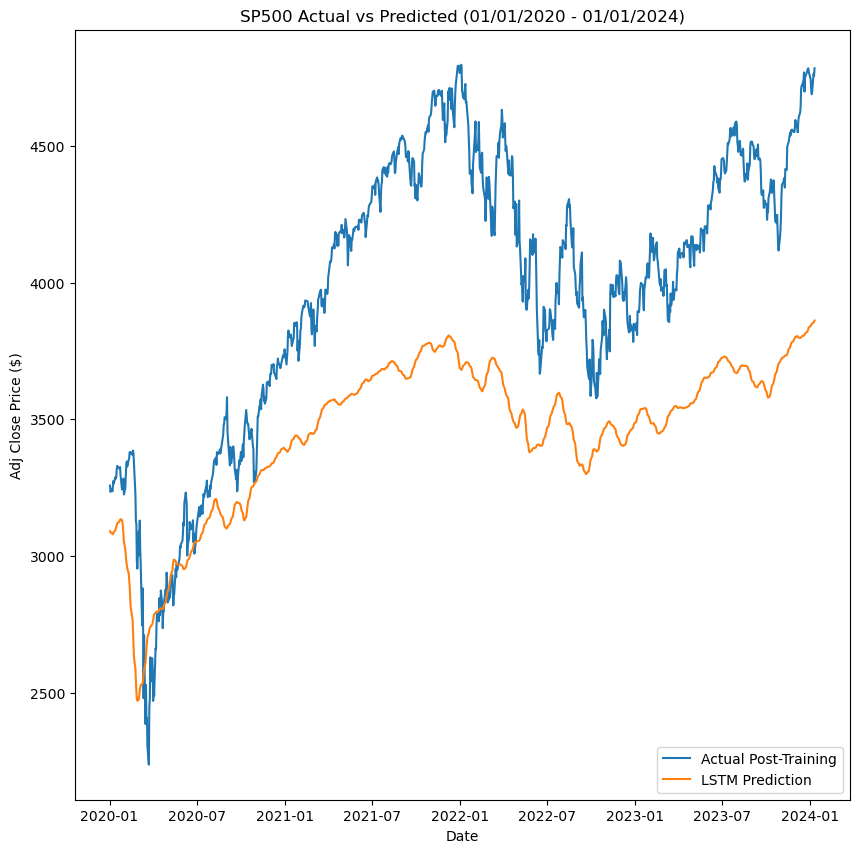

In [54]:
#plotting of graphs - Full Overview

train = trainingData['Adj Close']
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2020 - 01/01/2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(train)
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Pre-Training', 'Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

#plotting of graphs - Full Overview
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2020 - 01/01/2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()